# To do list for automatic Gaussian-Process

1) Uptake of the registered fluorescence slice and corresponding Raman data
    Construct cell with all variables that have to be set by hand
    a) All I/O - paths for files and saves
    b) Threshold for fluorescence split
    
    
2) Generalization of the GP-script to inputs from the I/O - cell

3) Change x-axis of GP to wavenumbers and combine both wavenumber-intervals in one representation (HFR and FP)
    Conversion : No. of Raman images in one set and the wave numbers they spread over are necessary
    
4) Split data sets into training, validation and test set

5) Establish a proper method to determine whether a spectrum of points is more likely to correspond to non-fluorescence or
   fluorescence conditions (probably pointwise distance to reference spectra)
   
6) Establish metrics to analyze the classification efficiency (standards (precision, accuracy, ...))

7) Create meaningful graphical representations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
from skimage import color
import tempfile
import os
from timeit import default_timer as timer
from tempfile import TemporaryFile
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared
import decimal
from decimal import *
from sklearn.gaussian_process.kernels import ConstantKernel

In [2]:
#Parameters defined by the user


# Enter the folder path were the Raman images are stored and  add the last few letters and the  file ending
# Example : Path_Raman_data = 'D:\\Arbeit\\Patient 22\\Slide14, cut29\\SRS\\Images\\ROI1\\HFR', 'ch02.tif'
HFR_Path_Raman_data, HFR_Ending_Raman_data  = 'D:\Arbeit\Patient 22\Slide14, cut29\SRS\Images\ROI1\HFR', 'ch02.tif'

FP_Path_Raman_data, FP_Ending_Raman_data  = 'D:\Arbeit\Patient 22\Slide14, cut29\SRS\Images\ROI1\FP', 'ch02.tif'

# Enter the folder path were the registered fluorescence image information is stored and add the file name
# Example : Path_Fluo_reg = 'D:\\Arbeit\\Patient 22\\Slide14, cut29\\Opti_slice.npy'
Path_Fluo_reg = 'D:\Arbeit\Patient 22\Slide14, cut29\Opti_slice.npy'

# # Enter the folder path were the alpha-synuclein Fluorescence images are stored and add the last few letters and the
# file ending
aSYN_Path_Fluo_data, aSYN_Ending_Fluo_data = 'D:\Arbeit\Patient 22\Slide14, cut29\Fluorescence\Fluorescence', 'paSyn.tif'

# Determine the percentual (0-1) threshold applied on the fluorescence maximum intensity to split the fluorescence data in
# fluorescent and virtually non-fluorescent data points
Fluo_thresh_perc = 0.5


#Save paths and filenames for:

Save_Folder = 'D:\Arbeit\Patient 22\Slide14, cut29\ '
# aaabbb
Save_a = Save_Folder+'a'
Save_b = Save_Folder+'b'

#cccddd
Save_c = Save_Folder+'c'
Save_d = Save_Folder+'d'


#eeefff
Save_e = Save_Folder+'e'

Save_f = Save_Folder+'f'


#Definition of kernels for the Gaussian process
#Define the Gauss process for regression and its Kernel (important parameter to adjust is length_scale and the scaling factor
# S_1 (default=1))
S_1 = 1
#Radial-basis-function kernel
kernel_dem = S_1*RBF(length_scale=(1), length_scale_bounds=(0.1, 10))
kernel_1 = S_1* RBF(length_scale=(1), length_scale_bounds=(0.000001, 1000000))
kernel_2 = S_1* RBF(length_scale=(100), length_scale_bounds=(100, 1000))
kernel_3 = S_1* ExpSineSquared(length_scale=100, periodicity=1.0, length_scale_bounds=(0.01, 100), periodicity_bounds=(1.0, 100))

#Set kernel to the active kernel used for the iteration of the following Gaussian process
kernel = kernel_1

#No. of restarts for the Gaussian process

restarts = 100

In [3]:
#Create a correctly spaced x-axis for GP presentation based on the used wavenumbers

#Only FP-region 

FP_max = 1598.8
FP_min = 1780.0

FP_diff = FP_min - FP_max
#Number of tested WN in FP-region
FP_WN = 36
FP_step = FP_diff/FP_WN

FP_x_axis = np.linspace(FP_min, FP_max, num=FP_WN)

#Create a correctly spaced x-axis for GP presentation based on the used wavenumbers

#Only HFR-region 

HFR_max = 2796.6
HFR_min = 3050.0

HFR_diff = HFR_min - HFR_max
#Number of tested WN in HFR-region
HFR_WN = 33
HFR_step = HFR_diff/HFR_WN

HFR_x_axis = np.linspace(HFR_min, HFR_max, num=HFR_WN)


#Both axes combined

Comb_x_axis = np.append(HFR_x_axis, FP_x_axis)

In [4]:
#Function to load in picture data in the format (XxZ) and
#reshape it to (XxY, 1) and give them out in list format.
#Example path: '/bph/puredata1/raman/SP8 Leica/data/PD/skin/exported data/patient 15A, test slide 2/cut 1/ROI 1/HFR (2789-3011)'
#File ending determines the channel used for picture acquisition
#Example file ending: "ch00.tif"
#Pictures are also grayscaled
def Raw_Plus_Loader(Path, file_ending):
    
    path = Path
    os.chdir(path)
    directory = os.fsencode(path)
    
    sorted_dir = sorted(os.listdir(directory))
    raw_tif_data = []
    raw_data = []
    for file in sorted_dir:
        try:
            filename = os.fsdecode(file)
            if filename.endswith(file_ending):
                print("Reading image: " + filename)
                raw = plt.imread(filename)
                print(raw.shape)
                raw_data.append(raw)
                grayscaled_raw = color.rgb2gray(raw)
                
                raw_tif_data.append(grayscaled_raw)
        except ValueError:
            print('Not an image')
            continue
    
    #Reshaping to 2D
    Reshaped_picture_data = []
    
    for i in raw_tif_data:
        reshaped_data = np.array(np.reshape(i, [-1, 1]))
        print(reshaped_data.shape)
        Reshaped_picture_data.append(reshaped_data)
        
    del raw_tif_data
    return(Reshaped_picture_data, raw_data)
#Script inputs a 1-D numpy array of image fluorescence information and binarizes (0 and 1)the information in it by a 
#certain threshold value. The script writes all all values below a certain fluorescence intensity to 0 and all
#other values to 1. The certain may be set as a floating point value (Set_thresh = threshold value) or by a percentage
#value of the highest value in the dataset (Set_perc_thresh = percentage (0 to 1). Returns the binarized data array.
#Only one thresholding method may be used at one time
def Fluoresc_Thresholder(Fluor, Set_thresh=None, Set_perc_thresh=None):
    
    if Set_thresh != None and Set_perc_thresh != None:
        print('Not both thresholding arguments may be used at the same time, one has to be left out or manually set to None')
    
    elif Set_thresh != None:
        buffer = np.where(Fluor >= Set_thresh, Fluor, Fluor*0)
        
    elif Set_perc_thresh != None:
        buffer = np.where(Fluor >= (np.amax(Fluor)*Set_perc_thresh), Fluor, Fluor*0)
        
    binary_data = np.where(buffer == 0, buffer, 1)
    
    return(binary_data)

#Script to cut a given in image to a specified size by removing leftmost columns or topmost row until the image and
# the y- and y-dimensions are of the same size.
def Cutter(Image, y_dim, x_dim):
    Imbuffer = Image
    if y_dim > Imbuffer.shape[0]:
        print('Image already is smaller in y-direction than y_dim')
    
    elif x_dim > Imbuffer.shape[1]:
        print('Image already is smaller in x-direction than x_dim')
    
    while y_dim < Imbuffer.shape[0]:
        Imbuffer = np.delete(Imbuffer, 0, 0)
    while x_dim < Imbuffer.shape[1]:
        Imbuffer = np.delete(Imbuffer, 0, 1)
    
    return(Imbuffer)

#Reshape datapoints to a picture-like format with pixels given in horizontal x-dim and vertical y-dim
def Pict_print_viridis_selfAdj(Sample, figure_number, x_dim, y_dim):
        
    if Sample.shape == (y_dim*x_dim, 1):
        
        Pict = Sample.reshape(y_dim, x_dim)
           
    elif Sample.shape == (y_dim, x_dim):
        Pict = Sample
        
    elif Sample.shape == (y_dim*x_dim,):
        
        Pict = Sample.reshape(y_dim, x_dim)
    
    else:
        
        print('Sample not in shape. Please reshape target.')
    
    
    
    plt.figure(figure_number, figsize=(20, 20))
    plt.imshow(Pict, cmap='viridis')

In [5]:
def Fluo_thresholder(Fluo_ser, Fluo_thresh):
    #Create two datasets (non-fluorescent and fluorescent based on threshold)
    Fluo_over_thresh = Fluo_ser[Fluo_ser>Fluo_thresh]
    Fluo_under_thresh = Fluo_ser[Fluo_ser<=Fluo_thresh]
    Fluo_over_thresh_ind = Fluo_over_thresh.index
    Fluo_under_thresh_ind = Fluo_under_thresh.index
    
    return(Fluo_over_thresh, Fluo_under_thresh, Fluo_over_thresh_ind, Fluo_under_thresh_ind)

In [6]:
#Function to feed in groups of Raman images, with each group associated to one WN and stored in a Pandas series.
#Based on indices from fluorescence data, Raman data is selected
def Raman_selector(Ram_ser, Fluo_ind, Non_Fluo_ind):


    R_Fluo_list = []
    R_Non_Fluo_list = []
    
    for i in range(len(Ram_ser)):
        R_Fluo = Ram_ser[i].get(Fluo_ind)
        R_Non_Fluo = Ram_ser[i].get(Non_Fluo_ind)
        
        
        #append values for one wave number to a list of all WN
        R_Fluo_list.append(R_Fluo)
        R_Non_Fluo_list.append(R_Non_Fluo)
        
        
    return(R_Fluo_list, R_Non_Fluo_list)

In [7]:
# Routine to process input fluorescence and Raman data. Fluorescence data is thresholded by a set percentage value
# of the maximum intensity to determine between virtually non-fluorescent and fluorescent data. Data is converted to a
# Pandas series and indexed. These indices are taken to create corresponding data sets with the Raman data.
# Resulting data sets are sampled from to create training, validation and test data sets (60:20:20).
# Output consists of 9 different variables containing various Raman data:
# 1) Fluorescent training data
# 2) Non_fluorescent training data
# 3) Fluorescent validation data
# 4) Non-fluorescent validation data
# 5) Fluorescent test data
# 6) Non_fluorescent test data
# 7) Training data
# 8) Validation data
# 9) Test data


def GP_processor(Fluo_slice, Fluo_thresh_perc, Raman_input, a_syn_whole):
    
    # Linearize data from the registered fluorescence image slice

    Fluo_slice_lin = np.reshape(Fluo_slice, (-1,))
    print('Shape of Fluo_slice: ' + str(Fluo_slice.shape))
    print('Shape of linear Fluo_slice: ' + str(Fluo_slice_lin.shape))
    
    #Convert to Pandas series
    Fluo_ser = pd.Series(Fluo_slice_lin)
    
    #Sample 3 times for training, validation and test (60:20:20)
    
    F_train, F_validate, F_test = \
        np.split(Fluo_ser.sample(frac=1, random_state=42), [int(0.6*len(Fluo_ser)), int(0.8*len(Fluo_ser))])
    
    #Extract indices from the datasets
    F_train_ind = F_train.index
    F_validate_ind = F_validate.index
    F_test_ind = F_test.index

    
    #Convert Raman input data to a numpy array
    ram_dat_arr = np.array(Raman_input)
    
    #Convert Raman data to a Pandas series
    Ram_ser = []
    for i in range(ram_dat_arr.shape[0]):
        ser_buffer = pd.Series(np.reshape(ram_dat_arr[i], (-1, )))
        Ram_ser.append(ser_buffer)
        
    #Create training, validation and test data set for the Raman data based on the indices from the fluorescence groups
    R_train_list = []
    R_validate_list = []
    R_test_list = []
    for i in range(len(Ram_ser)):
        R_train = Ram_ser[i].get(F_train_ind)
        R_validate = Ram_ser[i].get(F_validate_ind)
        R_test = Ram_ser[i].get(F_test_ind)
        
        #append values for one wave number to a list of all WN
        R_train_list.append(R_train)
        R_validate_list.append(R_validate)
        R_test_list.append(R_test)
    
    #Determine max. fluo. value, set threshold for fluo.
    Fluo_max = np.amax(a_syn_whole)
    Fluo_thresh = Fluo_max*Fluo_thresh_perc
    print('Fluorescence threshold is at ' + str(Fluo_thresh_perc*100) + '% and is at value ' + str(Fluo_thresh))
    
    #Get data and corresponding indices for Fluo. value above or below the set threshold
    F_train_Fluo, F_train_Non, F_train_Fluo_ind, F_train_Non_ind = Fluo_thresholder(F_train, Fluo_thresh)
    
    F_validate_Fluo, F_validate_Non, F_validate_Fluo_ind, F_validate_Non_ind = Fluo_thresholder(F_validate, Fluo_thresh)
    
    F_test_Fluo, F_test_Non, F_test_Fluo_ind, F_test_Non_ind = Fluo_thresholder(F_test, Fluo_thresh)
    

    #Get corresponding Raman data
    
    R_train_Fluo, R_train_Non_Fluo = Raman_selector(Ram_ser, F_train_Fluo_ind, F_train_Non_ind)
    R_validate_Fluo, R_validate_Non_Fluo = Raman_selector(Ram_ser, F_validate_Fluo_ind, F_validate_Non_ind)
    R_test_Fluo, R_test_Non_Fluo = Raman_selector(Ram_ser, F_test_Fluo_ind, F_test_Non_ind)
    
    
    return(R_train_Fluo, R_train_Non_Fluo, R_validate_Fluo, R_validate_Non_Fluo, R_test_Fluo, R_test_Non_Fluo, R_train_list, R_validate_list, R_test_list)
    
    
    
    
    
    
    


In [8]:
#Function to calculate statistical necessities for the GP modelling
#This includes calculation of mean, SD, an the quotient between SD and mean that is helpful to add an error value
#to the following modelling process

def GP_calculator(Raman_input):
    #Mean calculation
    means = []
    
    for i in range(len(Raman_input)):
        mean_buffer = np.mean(Raman_input[i])
        
        means.append(mean_buffer)
        
    means_array = np.array(means)
    
    #SD calculation
    SD = []
    
    for j in range(len(Raman_input)):
        SD_buffer = np.std(Raman_input[j])
        
        SD.append(SD_buffer)
        
    SD_array = np.array(SD)
    
    SD_mean_quot = []
    
    for k in range(len(Raman_input)):
        quot_buffer = SD_array[k]/means_array[k]
        
        SD_mean_quot.append(quot_buffer)
        
    quot_array = np.array(SD_mean_quot)
    
    return(means_array, SD_array, quot_array)
    
        

In [9]:
def GP_Fitter(kernel, restarts, quot, WN_x_axis, means):
    
    #Definition of the Gaussian process
    #Contains alpha, that adds a set of values to the diagonal of the covariance matrix to simulate noise,
    #experimentally alpha is the quotient between a mean and its corresponding SD it is simply added to the diagonal variance
    #entries of the covariance matrix that normally are just 1 (1 + 1 * quotient)
    #is set to normalize_y=True so that the GP uses a fed in mean for calculations instead of a standard mean = 0
    #uses a set of predefined kernels and uses an optimizer to enhance the kernel parameters S_1 and length_scale

    gp_init = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=restarts, alpha=(quot), normalize_y=True)


    #Fitting the initialized GP to actual data corresponding to a fitting x_Axis defined by the wavenumbers tested for the
    #dataset of means

    gp_fit = gp_init.fit(np.reshape(WN_x_axis, (-1, 1)), means)
    
    return(gp_fit)

    



In [10]:
random_int = np.reshape(((np.random.rand(1, 69))/3.5), (1, 69))

In [11]:
random_int[0].shape

(69,)

In [12]:
def GP_predict(WN_x_axis, gp_fit, means, plot=True):
    
    #Prediction of values from the GP and sampling from curves to create a model of our data
    #Printing a graphical presentation of the Gaussian process model with x-axis as wavenumbers and y-axis as Raman
    #intensity. The black curve is the mean of all samples from the Gaussian process and enveloped by a grey tubular
    #representation of one standard deviation. A scatterplot shows the mean values the GP was modeled after

    X = WN_x_axis #Interval of numbers to perform the process over
    X_resh = np.reshape(X, (X.shape[0], 1))
    y_mean, y_std = gp_fit.predict(X_resh, return_std=True) #Prediction using the GP with  training
    y_samples = gp_fit.sample_y(X_resh, 15) #Sample 15 curves ()
    
    if plot == True:
        #Plotting the data
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=False)
        fig.subplots_adjust(wspace=0.2)
        fig.suptitle('Raman intensities on each wavenumber')
        
        
        #ax1.figure(figsize=(6,6))
        #ax2.figure(figsize=(6,6)) 
        
        ax1.plot(X, y_mean, 'k', lw=3, zorder=9)
        ax1.scatter(WN_x_axis, means, c='r', s=50, zorder=10, edgecolors=(0, 0 ,0))
        ax1.fill_between(X, y_mean-y_std, y_mean+y_std, alpha=0.2, color='k')
        ax1.set_title('High-frequency-region')
        
        ax2.plot(X, y_mean, 'k', lw=3, zorder=9)
        ax2.scatter(WN_x_axis, means, c='r', s=50, zorder=10, edgecolors=(0, 0 ,0))
        ax2.fill_between(X, y_mean-y_std, y_mean+y_std, alpha=0.2, color='k')
        ax2.set_title('Fingerprint-region')
        
        ax1.set(xlabel='Wavenumber (WN)', ylabel='Intensity')
        ax2.set(xlabel='Wavenumber (WN)', ylabel='Intensity')
              
        ax1.set_xlim(3050, 2796.6)
        ax1.set_ylim(0, 0.4)
        ax2.set_xlim(1780, 1598.8)
        ax2.set_ylim(0, 0.4)               
        
        return(y_mean)
    else:
        return(y_mean)

In [13]:
#Classifier to predict fluorescence or non-fluorescence for single pixels in the Raman images; only feed in a list with
# all WN (HFR first) combined, where each WN carries all pixel values of the corresponding set (training, validation,
# test)
def GP_classifier(data, pred_zero, pred_fluo, ref_zero, ref_fluo):
    
    p_zero = np.array(pred_zero)
    p_fluo = np.array(pred_fluo)
    
    TN = 0
    FN = 0
    TP = 0
    FP = 0
    
    #convert data format from 33 WN with each holding one datapoint per point one the image,
    #to every single datapoint holding its wave numbers
    c_data = []

    for i in range(len(data[0])):

        data_buffer = []
        for j in range(len(data)):
            buffer = data[j].iloc[i]
            data_buffer.append(buffer)
        c_data.append(data_buffer)
    
    
    
    
    for i in range(len(c_data)):
        
        switch = 2
    
        dist_zero = np.sum(np.abs(c_data[i] - p_zero))
        dist_fluo = np.sum(np.abs(c_data[i] - p_fluo))
        
        if dist_zero > dist_fluo:
            switch = 1
        
        elif dist_zero < dist_fluo:
            switch = 0
            
        else:
            print('Switch could not be set')
            
        ref_switch = 2
        if data[0].index[i] in ref_fluo[0]:
            
            ref_switch = 1
            
        elif data[0].index[i] in ref_zero[0]:
            
            ref_switch = 0
        
        else:
            print('ref_Switch could not be set')
            
        if switch == 0 and ref_switch == 0:
            
            TN = TN+1
            
            print('TN = '+str(TN))
            
        elif switch == 0 and ref_switch == 1:
            
            FN = FN+1
            
            print('FN = '+str(FN))
            
        elif switch == 1 and ref_switch == 1:
            
            TP = TP+1
            
            print('TP = '+str(TP))
            
        elif switch == 1 and ref_switch == 0:
            
            FP = FP+1
            
            print('FP = '+str(FP))
            
        else:
            print('Classification could not be processed.')
            
            
    return(TP, FP, TN, FN)

In [14]:
Fluo_slice = np.load('D:\\Arbeit\\Patient 22\\Slide14, cut29\\ Opti_slice.npy')

In [15]:
#Load in the whole fluorescence image of the a-synuclein channel
aSYN_Fluo, aSYN_Fluo_raw = Raw_Plus_Loader(aSYN_Path_Fluo_data, aSYN_Ending_Fluo_data)

Reading image: Fluo_paSyn.tif


C:\Users\Philip\anaconda3\envs\ACT_Ker\lib\site-packages\PIL\Image.py:2858: DecompressionBombWarning: Image size (89488860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


(13110, 6826, 3)
(89488860, 1)


In [16]:
a_syn_array = np.reshape(np.array(aSYN_Fluo), (-1))

In [17]:
#Load in all the HFR_Raman image data that are corresponding to the registered fluorescence slice
HFR_ram_dat, HFR_ram_raw = Raw_Plus_Loader(HFR_Path_Raman_data, HFR_Ending_Raman_data)

Reading image: Slide14_cut(right)_SRS_ROI1_HFR280121_LA00_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_HFR280121_LA01_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_HFR280121_LA02_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_HFR280121_LA03_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_HFR280121_LA04_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_HFR280121_LA05_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_HFR280121_LA06_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_HFR280121_LA07_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_HFR280121_LA08_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_HFR280121_LA09_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_HFR280121_LA10_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_HFR280121_LA11_ch02.tif
(1024, 1024, 3)
Read

In [18]:
#Load in all the FP_Raman image data that are corresponding to the registered fluorescence slice
FP_ram_dat, FP_ram_raw = Raw_Plus_Loader(FP_Path_Raman_data, FP_Ending_Raman_data)

Reading image: Slide14_cut(right)_SRS_ROI1_FP280121_LA00_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_FP280121_LA01_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_FP280121_LA02_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_FP280121_LA03_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_FP280121_LA04_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_FP280121_LA05_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_FP280121_LA06_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_FP280121_LA07_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_FP280121_LA08_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_FP280121_LA09_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_FP280121_LA10_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI1_FP280121_LA11_ch02.tif
(1024, 1024, 3)
Reading image: S

In [19]:
#Process HFR data
HFR_R_train_Fluo, HFR_R_train_Non_Fluo, HFR_R_validate_Fluo, HFR_R_validate_Non_Fluo, HFR_R_test_Fluo, HFR_R_test_Non_Fluo, HFR_R_train, HFR_R_validate,HFR_R_test = GP_processor(Fluo_slice, Fluo_thresh_perc, HFR_ram_dat, a_syn_array)

Shape of Fluo_slice: (1024, 1024)
Shape of linear Fluo_slice: (1048576,)
Fluorescence threshold is at 50.0% and is at value 0.03605


In [20]:
#Process FP data
FP_R_train_Fluo, FP_R_train_Non_Fluo, FP_R_validate_Fluo, FP_R_validate_Non_Fluo, FP_R_test_Fluo, FP_R_test_Non_Fluo, FP_R_train, FP_R_validate, FP_R_test = GP_processor(Fluo_slice, Fluo_thresh_perc, FP_ram_dat, a_syn_array)

Shape of Fluo_slice: (1024, 1024)
Shape of linear Fluo_slice: (1048576,)
Fluorescence threshold is at 50.0% and is at value 0.03605


In [21]:
#Process HFR data in all three groups
HFR_R_t_F_mean, HFR_R_t_F_SD, HFR_R_t_F_quot = GP_calculator(HFR_R_train_Fluo)
HFR_R_t_N_mean, HFR_R_t_N_SD, HFR_R_t_N_quot = GP_calculator(HFR_R_train_Non_Fluo)
HFR_R_v_F_mean, HFR_R_v_F_SD, HFR_R_v_F_quot = GP_calculator(HFR_R_validate_Fluo)
HFR_R_v_N_mean, HFR_R_v_N_SD, HFR_R_v_N_quot = GP_calculator(HFR_R_validate_Non_Fluo)
HFR_R_te_F_mean, HFR_R_te_F_SD, HFR_R_te_F_quot = GP_calculator(HFR_R_test_Fluo)
HFR_R_te_N_mean, HFR_R_te_N_SD, HFR_R_te_N_quot = GP_calculator(HFR_R_test_Non_Fluo)

In [22]:
#Process FP data in all three groups
FP_R_t_F_mean, FP_R_t_F_SD, FP_R_t_F_quot = GP_calculator(FP_R_train_Fluo)
FP_R_t_N_mean, FP_R_t_N_SD, FP_R_t_N_quot = GP_calculator(FP_R_train_Non_Fluo)
FP_R_v_F_mean, FP_R_v_F_SD, FP_R_v_F_quot = GP_calculator(FP_R_validate_Fluo)
FP_R_v_N_mean, FP_R_v_N_SD, FP_R_v_N_quot = GP_calculator(FP_R_validate_Non_Fluo)
FP_R_te_F_mean, FP_R_te_F_SD, FP_R_te_F_quot = GP_calculator(FP_R_test_Fluo)
FP_R_te_N_mean, FP_R_te_N_SD, FP_R_te_N_quot = GP_calculator(FP_R_test_Non_Fluo)

In [23]:
FP_R_train_Fluo[0].shape

(24597,)

In [24]:
FP_R_train_Non_Fluo[0].shape

(604548,)

In [25]:
F_t_fit = GP_Fitter(kernel, restarts, np.append(HFR_R_t_F_SD, FP_R_t_F_SD) , Comb_x_axis, np.append(HFR_R_t_F_mean, FP_R_t_F_mean))

In [26]:
N_t_fit = GP_Fitter(kernel, restarts, np.append(HFR_R_t_N_SD, FP_R_t_N_SD) , Comb_x_axis, np.append(HFR_R_t_N_mean, FP_R_t_N_mean))

In [27]:
HFR_R_t_N_quot

array([2.52861078, 2.60001855, 2.67971955, 2.70398007, 2.50848399,
       2.32914928, 2.06466966, 1.88322232, 1.71987339, 1.55583619,
       1.43363093, 1.33961182, 1.24050573, 1.22248789, 1.25528762,
       1.33097019, 1.47775161, 1.52164959, 1.60658045, 1.61410237,
       1.62996325, 1.71806667, 1.85182757, 2.04760918, 2.1686856 ,
       2.40333515, 2.3078336 , 2.15237617, 2.11283247, 2.03177775,
       2.11880212, 2.04470761, 2.02944254])

In [28]:
HFR_R_t_F_quot

array([2.07310567, 2.13009731, 2.19881859, 2.24958944, 2.12037518,
       1.8771956 , 1.42589432, 1.0780025 , 0.80112347, 0.6803102 ,
       0.62052446, 0.5807349 , 0.56968949, 0.59130304, 0.60463644,
       0.615286  , 0.62713547, 0.64258218, 0.68152026, 0.70760634,
       0.71536097, 0.75972211, 0.92562117, 1.23439289, 1.5634979 ,
       1.94939832, 1.80468739, 1.58571515, 1.47119366, 1.47395721,
       1.45426378, 1.43272113, 1.44575434])

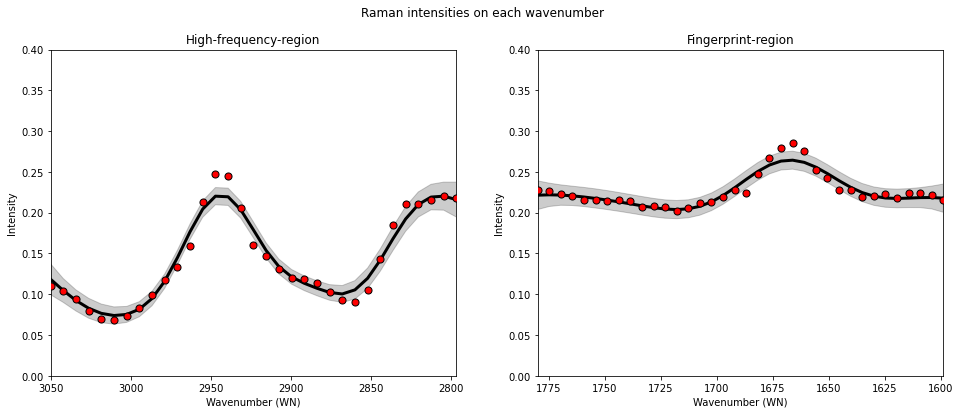

In [29]:
F_t_predict = GP_predict(Comb_x_axis, F_t_fit, np.append(HFR_R_t_F_mean, FP_R_t_F_mean))

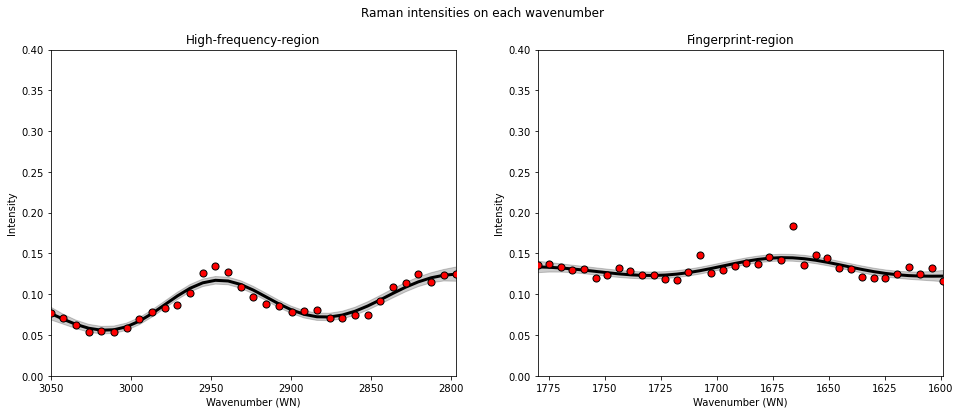

In [30]:
N_t_predict = GP_predict(Comb_x_axis, N_t_fit, np.append(HFR_R_t_N_mean, FP_R_t_N_mean))

In [31]:
N_t_predict.shape

(69,)

In [ ]:
Comb_HFR_FP_R_train = HFR_R_train + FP_R_train

In [ ]:
TP, FP, TN, FN = GP_classifier(Comb_HFR_FP_R_train, N_t_predict, F_t_predict, HFR_R_train_Non_Fluo, HFR_R_train_Fluo)

In [ ]:
#TP, FP, TN, FN = GP_classifier(R_train, N_t_pred, F_t_pred, R_train_Non_Fluo, R_train_Fluo)

In [ ]:
TP

In [ ]:
FP

In [ ]:
TN

In [ ]:
FN

In [ ]:
Accuracy = ((TP+TN)/(TP+TN+FP+FN))
print(Accuracy)

In [ ]:
#Sensitivity or Recall; rate of TP on all positives
Recall = ((TP)/(TP+FN))
print(Recall)

In [ ]:
Misclass = ((FP+FN)/(TP+TN+FP+FN))
print(Misclass)

In [ ]:
#Percentage of correct TP predictions
Precision = ((TP)/(TP+FP))
print(Precision)

In [ ]:
F1_score = 2*((Precision*Recall)/(Precision+Recall))
print(F1_score)

In [ ]:
Accuracy = ((TP+TN)/(TP+TN+FP+FN))
print(Accuracy)
#Sensitivity or Recall; rate of TP on all positives
Recall = ((TP)/(TP+FN))
print(Recall)
Misclass = ((FP+FN)/(TP+TN+FP+FN))
print(Misclass)
#Percentage of correct TP predictions
Precision = ((TP)/(TP+FP))
print(Precision)
#F1 score
F1_score = 2*((Precision*Recall)/(Precision+Recall))
print(F1_score)